In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [32]:
load_path = "../../data/fraudTest.csv"

# Loading the data
df = pd.read_csv(load_path)

In [33]:
# Loading the data
df = pd.read_csv(load_path)

# Drop the column named 'Unnamed: 0' (unnecessary index column)
df = df.drop(columns=['Unnamed: 0'])

# Convert date/time columns
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], errors='coerce')
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')

# Keep IDs as string/object
df['cc_num'] = df['cc_num'].astype(str)
df['trans_num'] = df['trans_num'].astype(str)

# Convert categorical/text columns
categorical_cols = ['merchant', 'category', 'first', 'last', 'gender', 
                    'street', 'city', 'state', 'zip', 'job']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Convert to Unix timestamp (in seconds)
df['unix_trans_time'] = df['trans_date_trans_time'].astype('int64') // 10**9
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days / 365.25 # account for leap years

# Compute number of distinct categories per merchant
merchant_category_counts = df.groupby("merchant")["category"].transform("nunique")
# Add it as a new column
df["nb_categories"] = merchant_category_counts

/tmp/ipykernel_124081/859776737.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merchant_category_counts = df.groupby("merchant")["category"].transform("nunique")


In [34]:
# Create numeric IDs for graph nodes (cards, merchants, transactions)

# treat each unique card number as a category
card_ids = df["cc_num"].astype("category").cat.codes
# Add a new column card_id
df["card_id"] = card_ids

# treat each unique merchant as a category
merchant_ids = df["merchant"].astype("category").cat.codes
# Add a new column merchant_id
df["merchant_id"] = merchant_ids

# Each row is one transaction
df["transaction_id"] = range(len(df))


In [35]:
# Fenêtre temporelle par défaut (en secondes) pour les premières transactions
FEATURE_WINDOW = 3600

# ----------------------------------------------------
# Encodage des variables catégorielles
# ----------------------------------------------------
df["category_idx"] = df["category"].astype("category").cat.codes
df["gender_idx"] = df["gender"].astype("category").cat.codes
df["job_idx"] = df["job"].astype("category").cat.codes

# ----------------------------------------------------
# Features temporelles
# ----------------------------------------------------
df["hour"] = df["trans_date_trans_time"].dt.hour
df["dayofweek"] = df["trans_date_trans_time"].dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

# ----------------------------------------------------
# Tri global pour toutes les features historiques
# ----------------------------------------------------
df = df.sort_values(["card_id", "unix_trans_time"]).reset_index(drop=True)

# ----------------------------------------------------
# Jump de temps depuis la transaction précédente
# ----------------------------------------------------
df["card_time_since_prev_tx"] = (
    df.groupby("card_id")["unix_trans_time"].diff().fillna(FEATURE_WINDOW)
)
# Optionnel : log-transform pour stabiliser les grandes valeurs
df["card_time_since_prev_tx_log"] = np.log1p(df["card_time_since_prev_tx"])

# ----------------------------------------------------
# Montant historique de la carte
# ----------------------------------------------------
df["card_amt_mean"] = (
    df.groupby("card_id")["amt"].expanding().mean().shift().reset_index(level=0, drop=True)
).fillna(0)

df["card_amt_std"] = (
    df.groupby("card_id")["amt"].expanding().std().shift().reset_index(level=0, drop=True)
).fillna(0)

df["card_amt_max"] = (
    df.groupby("card_id")["amt"].expanding().max().shift().reset_index(level=0, drop=True)
).fillna(0)

df["card_amt_min"] = (
    df.groupby("card_id")["amt"].expanding().min().shift().reset_index(level=0, drop=True)
).fillna(0)

# Écarts au max/min historique
df["amt_minus_prev_max"] = df["amt"] - df["card_amt_max"]
df["amt_minus_prev_min"] = df["amt"] - df["card_amt_min"]

# ----------------------------------------------------
# Z-score du montant
# ----------------------------------------------------
MIN_TX = 2
df["card_tx_count"] = df.groupby("card_id").cumcount()
df["amt_zscore"] = np.where(
    df["card_tx_count"] < MIN_TX,
    0,
    (df["amt"] - df["card_amt_mean"]) / (df["card_amt_std"] + 1e-6)
)

# ----------------------------------------------------
# Distances géographiques
# ----------------------------------------------------
def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371.0  # rayon Terre en km
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# Coordonnées du marchand précédent
df["prev_merch_lat"] = df.groupby("card_id")["merch_lat"].shift()
df["prev_merch_long"] = df.groupby("card_id")["merch_long"].shift()

# Distance à la transaction précédente
df["dist_from_prev_tx"] = haversine_np(
    df["merch_lat"], df["merch_long"],
    df["prev_merch_lat"], df["prev_merch_long"]
).fillna(0)

# Distance par rapport à l'adresse du propriétaire
df["dist_from_home"] = haversine_np(
    df["merch_lat"], df["merch_long"],
    df["lat"], df["long"]
)

# ----------------------------------------------------
# Merchant features
# ----------------------------------------------------
# Nouveau merchant pour la carte
df["is_new_merchant"] = df.groupby("card_id")["merchant"].transform(lambda x: ~x.duplicated()).astype(int)

# ----------------------------------------------------
# Création d'un DataFrame dédié aux features merchant
# ----------------------------------------------------
df_merchant = (
    df[["transaction_id", "merchant_id", "unix_trans_time", "amt"]]
    # Tri indispensable pour garantir la cohérence temporelle
    .sort_values(["merchant_id", "unix_trans_time"])
    .reset_index(drop=True)
)

# ----------------------------------------------------
# Temps écoulé depuis la transaction précédente
# chez le même merchant
# ----------------------------------------------------
df_merchant["merchant_time_since_prev_tx"] = (
    df_merchant
    .groupby("merchant_id")["unix_trans_time"]
    .diff()
    .fillna(FEATURE_WINDOW)
)

# ----------------------------------------------------
# Montant moyen historique du merchant (jusqu'à t-1)
# ----------------------------------------------------
df_merchant["merchant_avg_amt"] = (
    df_merchant
    .groupby("merchant_id")["amt"]
    .expanding()
    .mean()
    .shift()
    .reset_index(level=0, drop=True)
    .fillna(0)
)

# ----------------------------------------------------
# Jointure avec le DataFrame principal
# ----------------------------------------------------
df = df.merge(
    df_merchant[
        ["transaction_id", "merchant_time_since_prev_tx", "merchant_avg_amt"]
    ],
    on="transaction_id",
    how="left"
)

In [36]:
preds_df = pd.read_csv("predictions.csv")

df = df.merge(
    preds_df[["transaction_id", "score", "prediction"]],
    on="transaction_id",
    how="left"
)


In [37]:
tx_id = 113452

features = [
    "trans_date_trans_time",
    "is_fraud",
    "prediction", "score", 

    # Transaction features
    "amt",
    "hour",
    "dayofweek",
    "is_weekend",
    "age",
    "is_new_merchant",
    "dist_from_home",
    "dist_from_prev_tx",
    "category",

    # Card features
    "amt_zscore",
    "amt_minus_prev_max",
    "amt_minus_prev_min",
    "card_amt_mean",
    "card_amt_std",

    # Identity
    "gender", "job",
    "city_pop",

    # Mercahnt feature
    "merchant_avg_amt",
    "merchant_time_since_prev_tx"
]

df.loc[df["transaction_id"] == tx_id, features].iloc[0].to_frame("value")

,value
trans_date_trans_time,2020-07-30 22:30:00
is_fraud,1
prediction,0
score,0.702923
amt,309.43
hour,22
dayofweek,3
is_weekend,0
age,26.817248
is_new_merchant,1


In [38]:
row_fn = df.loc[df["transaction_id"] == tx_id].iloc[0]
card_id = row_fn["card_id"]
fraud_time = row_fn["unix_trans_time"]

# Keep only past transactions
card_tx = (
    df[
        (df["card_id"] == card_id) &
        (df["unix_trans_time"] < fraud_time)
    ]
    .sort_values("unix_trans_time")[features]
)

pd.set_option('display.max_columns', None)
card_tx

,trans_date_trans_time,is_fraud,prediction,score,amt,hour,dayofweek,is_weekend,age,is_new_merchant,dist_from_home,dist_from_prev_tx,category,amt_zscore,amt_minus_prev_max,amt_minus_prev_min,card_amt_mean,card_amt_std,gender,job,city_pop,merchant_avg_amt,merchant_time_since_prev_tx
0,2020-06-21 15:41:32,0,0,0.689187,42.32,15,6,1,26.710472,1,70.573851,0.000000,kids_pets,0.000000,42.32,42.32,0.000000,0.000000,M,Manufacturing engineer,1504,62.795612,3600.0
1,2020-06-21 17:33:11,0,0,0.705056,60.11,17,6,1,26.710472,1,81.140257,27.744558,home,0.000000,17.79,17.79,42.320000,0.000000,M,Manufacturing engineer,1504,93.416667,5812.0
2,2020-06-21 18:15:55,0,0,0.541724,549.72,18,6,1,26.710472,1,84.649984,138.425153,travel,39.628582,489.61,507.40,51.215000,12.579430,M,Manufacturing engineer,1504,62.666899,3600.0
3,2020-06-21 20:49:21,0,0,0.538294,58.76,20,6,1,26.710472,1,87.823959,147.797254,food_dining,-0.550872,-490.96,16.44,217.383333,287.949416,M,Manufacturing engineer,1504,45.374000,1375.0
4,2020-06-21 22:08:56,0,0,0.701971,66.89,22,6,1,26.710472,1,103.643562,28.152449,food_dining,-0.446697,-482.83,24.57,177.727500,248.126818,M,Manufacturing engineer,1504,20.870000,34152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,2020-07-29 22:39:23,0,0,0.689917,75.61,22,2,0,26.814511,0,25.954627,93.837701,home,-0.250916,-491.85,48.38,101.059344,101.425864,M,Manufacturing engineer,1504,58.727315,9852.0
184,2020-07-29 23:34:10,0,0,0.689893,42.13,23,2,0,26.814511,0,82.813549,95.139067,kids_pets,-0.581136,-525.33,14.90,100.921033,101.165763,M,Manufacturing engineer,1504,56.958103,85541.0
185,2020-07-30 00:06:13,1,0,0.689847,11.21,0,3,0,26.817248,1,112.464339,30.528869,gas_transport,-0.885230,-556.25,-16.02,100.603243,100.983030,M,Manufacturing engineer,1504,64.094170,50714.0
186,2020-07-30 01:22:08,1,0,0.689792,291.80,1,3,0,26.817248,1,82.625590,189.085713,grocery_pos,1.899247,-275.66,280.59,100.122634,100.922810,M,Manufacturing engineer,1504,86.947099,670.0


In [39]:
# Total transactions
total_tx = card_tx.shape[0]

# Number of frauds
num_fraud = card_tx["is_fraud"].sum()

# Percentage
perc_fraud = (num_fraud / total_tx) * 100

print(f"Percentage of fraud transactions: {perc_fraud:.2f}%")


Percentage of fraud transactions: 1.60%


In [40]:
# Last transaction (fraud)
fn_tx = row_fn

# Compute historical stats
hist_stats = card_tx[[
    "amt", "amt_zscore", "amt_minus_prev_max", "amt_minus_prev_min", "dist_from_prev_tx", "dist_from_home","merchant_avg_amt", "merchant_time_since_prev_tx"
]].describe().T

# Add the FN transaction value
hist_stats["fn_tx"] = [
    fn_tx["amt"],
    fn_tx["amt_zscore"],
    fn_tx["amt_minus_prev_max"],
    fn_tx["amt_minus_prev_min"],
    fn_tx["dist_from_prev_tx"],
    fn_tx["dist_from_home"],
    fn_tx["merchant_avg_amt"],
    fn_tx["merchant_time_since_prev_tx"]
]

hist_stats

,count,mean,std,min,25%,50%,75%,max,fn_tx
amt,188.0,102.185904,102.345296,11.210000,60.345000,75.900000,96.592500,567.460000,309.430000
amt_zscore,188.0,0.170831,3.033372,-0.885230,-0.409485,-0.253983,-0.056572,39.628582,2.024950
amt_minus_prev_max,188.0,-442.043298,128.292893,-556.250000,-490.235000,-475.190000,-453.127500,489.610000,-258.030000
amt_minus_prev_min,188.0,72.921543,102.492578,-16.020000,31.757500,46.870000,67.067500,538.370000,298.220000
dist_from_prev_tx,188.0,101.101527,48.804617,0.000000,60.469705,95.244909,137.626292,228.856659,113.014793
dist_from_home,188.0,74.048536,28.851820,2.588686,55.622438,74.509019,94.831210,129.520904,77.251682
merchant_avg_amt,188.0,77.379037,40.343892,4.535556,55.585490,62.849072,93.634700,310.901250,116.144126
merchant_time_since_prev_tx,188.0,24535.984043,35616.057240,8.000000,3506.000000,9857.500000,33293.250000,258464.000000,59987.000000


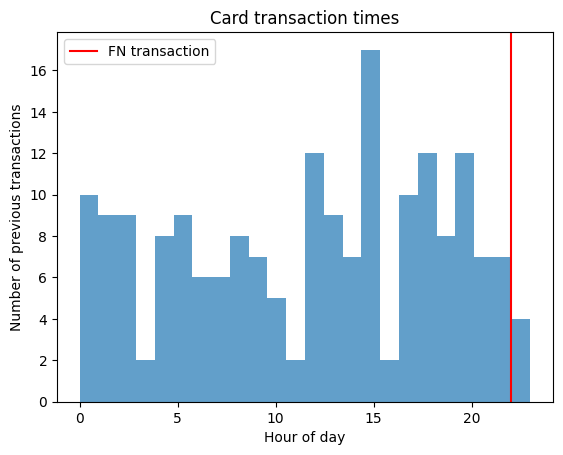

In [41]:
plt.hist(card_tx["hour"], bins=24, alpha=0.7)
plt.axvline(fn_tx["hour"], color="red", label="FN transaction")
plt.xlabel("Hour of day")
plt.ylabel("Number of previous transactions")
plt.title("Card transaction times")
plt.legend()
plt.show()


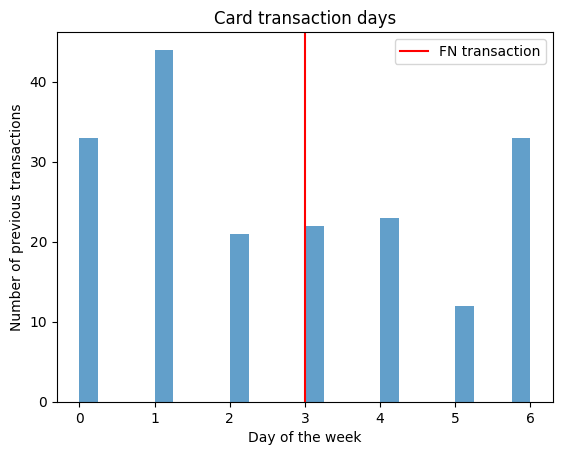

In [42]:
plt.hist(card_tx["dayofweek"], bins=24, alpha=0.7)
plt.axvline(fn_tx["dayofweek"], color="red", label="FN transaction")
plt.xlabel("Day of the week")
plt.ylabel("Number of previous transactions")
plt.title("Card transaction days")
plt.legend()
plt.show()
